In [1]:
!pip install pycaret -q

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.decomposition import PCA
from PIL import Image
from PIL import ImageEnhance

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# caminho_cafe_saudavel = '/content/drive/MyDrive/coffe/Saudavel'
caminho_cafe_saudavel = r'C:/Users/mathe/OneDrive/Documentos/Coffee_Data/Saudavel'
# caminho_cafe_nao_saudavel = '/content/drive/MyDrive/coffe/NSaudavel'
caminho_cafe_nao_saudavel = r'C:/Users/mathe/OneDrive/Documentos/Coffee_Data/NSaudavel'

In [8]:
def carregar_imagens(caminho):
    imagens = []
    for arquivo in os.listdir(caminho):
        imagem = cv2.imread(os.path.join(caminho, arquivo))
        imagem = cv2.resize(imagem, (224, 224)) 
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB) 
        imagens.append(imagem)
    return imagens

In [9]:
cafe_saudavel = carregar_imagens(caminho_cafe_saudavel)
cafe_nao_saudavel = carregar_imagens(caminho_cafe_nao_saudavel)

In [10]:
def data_augmentation(imagens):
    aumentadas = []
    for img in imagens:
        contrast = [np.asarray(ImageEnhance.Contrast(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.5, 1.5, 5)))) for _ in range(10)]
        brightness = [np.asarray(ImageEnhance.Brightness(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.5, 1.5, 5)))) for _ in range(10)]
        sharpness = [np.asarray(ImageEnhance.Sharpness(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.5, 1.5, 5)))) for _ in range(10)]
        color = [np.asarray(ImageEnhance.Color(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.5, 1.5, 5)))) for _ in range(10)]
        flip = [cv2.flip(img, np.random.choice([0, 1, -1])) if np.random.choice([0, 1]) else img for _ in range(10)]
        rotate = [Image.fromarray(img, 'RGB').rotate(np.random.choice([0, 90, 180, 270])) for _ in range(10)]
        
        aumentadas.append(img)
        aumentadas.extend(contrast)
        aumentadas.extend(brightness)
        aumentadas.extend(sharpness)
        aumentadas.extend(color)
        aumentadas.extend(flip)
        aumentadas.extend(rotate)
    
    return aumentadas

In [11]:
cafe_saudavel_aumentado = data_augmentation(cafe_saudavel)
cafe_nao_saudavel_aumentado = data_augmentation(cafe_nao_saudavel)

In [12]:
print("Tamanho do dataset de café saudável:", len(cafe_saudavel))
print("Tamanho do dataset de café não saudável:", len(cafe_nao_saudavel))
print("Tamanho do dataset de café saudável aumentado:", len(cafe_saudavel_aumentado))
print("Tamanho do dataset de café não saudável aumentado:", len(cafe_nao_saudavel_aumentado))

Tamanho do dataset de café saudável: 63
Tamanho do dataset de café não saudável: 60
Tamanho do dataset de café saudável aumentado: 3843
Tamanho do dataset de café não saudável aumentado: 3660


In [13]:
def exibir_exemplos(imagens, titulo):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    fig.suptitle(titulo, fontsize=16)
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(imagens[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

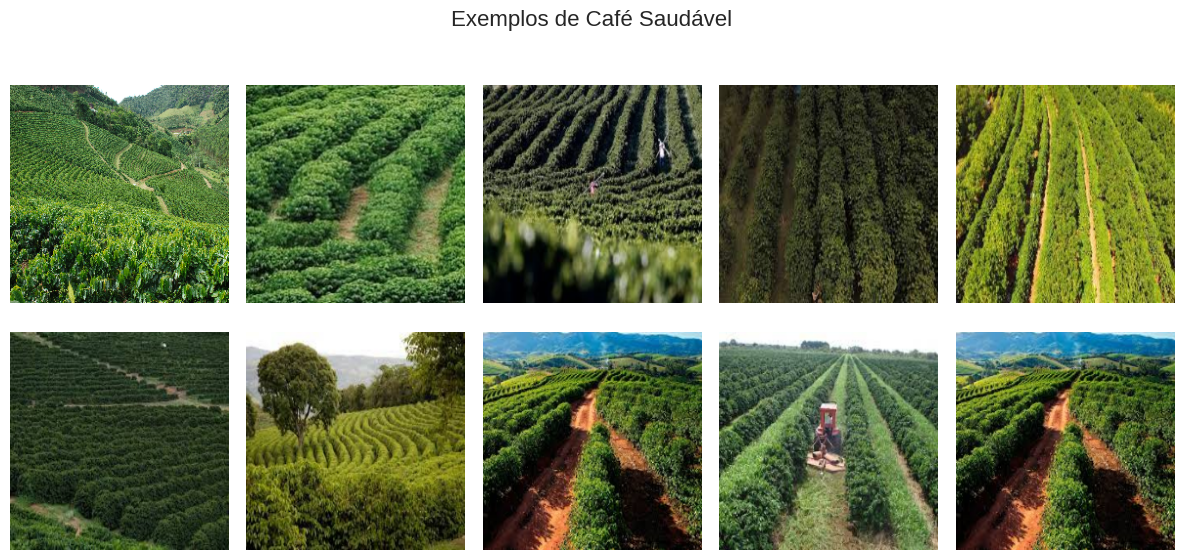

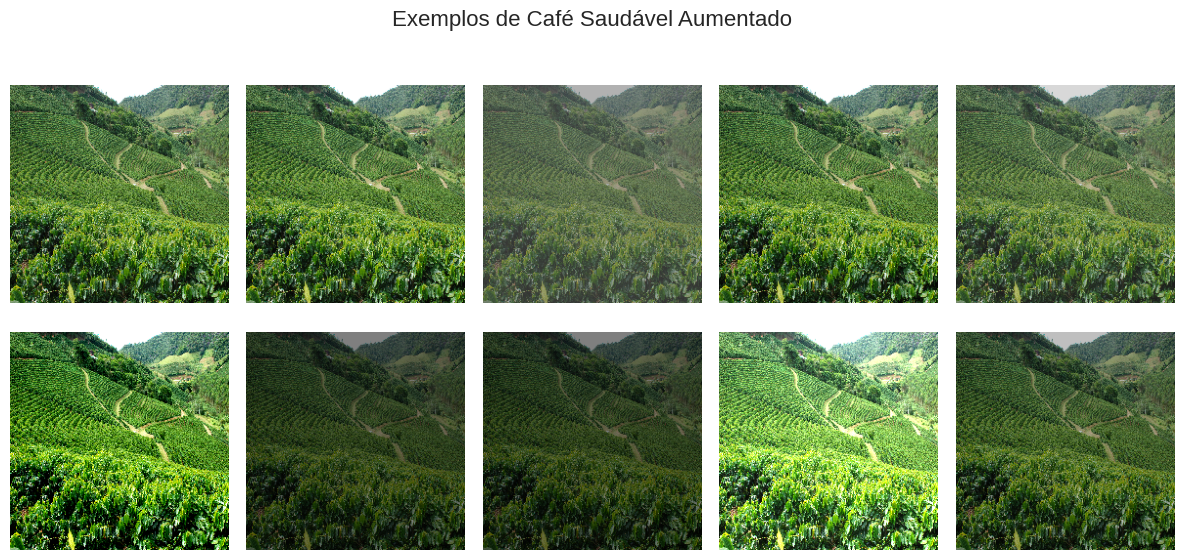

In [10]:
exibir_exemplos(cafe_saudavel, 'Exemplos de Café Saudável')
exibir_exemplos(cafe_saudavel_aumentado, 'Exemplos de Café Saudável Aumentado')

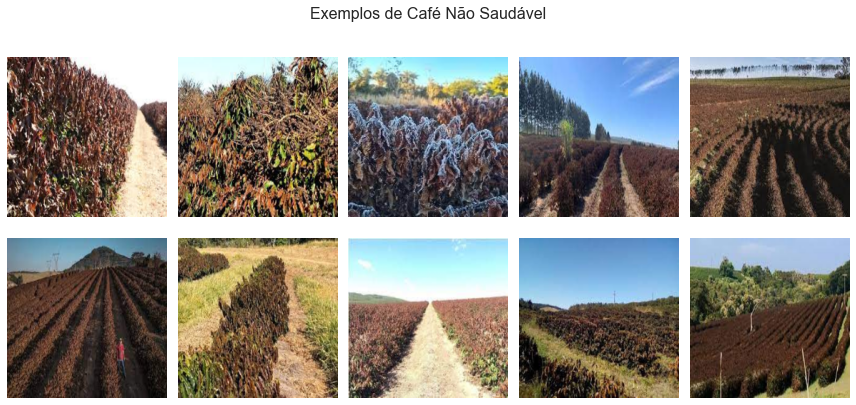

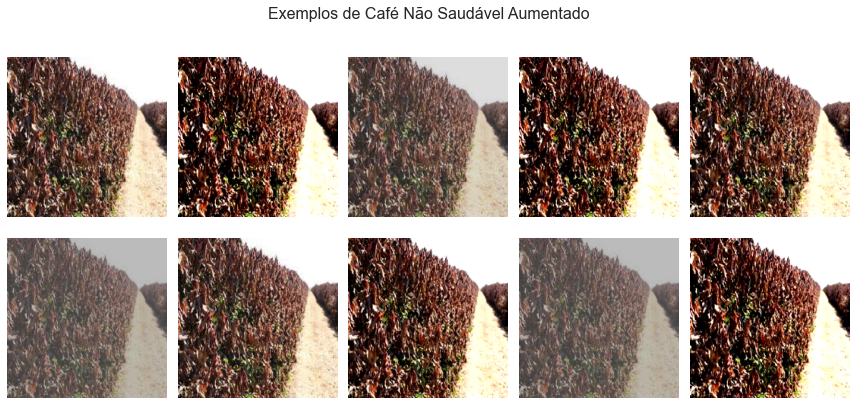

In [14]:
exibir_exemplos(cafe_nao_saudavel, 'Exemplos de Café Não Saudável')
exibir_exemplos(cafe_nao_saudavel_aumentado, 'Exemplos de Café Não Saudável Aumentado')

In [15]:
rotulos_cafe_saudavel_aumentado = np.ones(len(cafe_saudavel_aumentado))
rotulos_cafe_nao_saudavel_aumentado = np.zeros(len(cafe_nao_saudavel_aumentado))

In [16]:
imagens = np.stack(cafe_saudavel_aumentado + cafe_nao_saudavel_aumentado)
rotulos = np.concatenate((rotulos_cafe_saudavel_aumentado, rotulos_cafe_nao_saudavel_aumentado))

In [17]:
imagens[0]

array([[[101, 142,  89],
        [ 95, 125,  78],
        [ 38,  62,  42],
        ...,
        [107, 119, 115],
        [ 93, 126,  83],
        [ 54,  74,  71]],

       [[ 50,  79,  43],
        [ 61,  98,  55],
        [ 87, 124,  72],
        ...,
        [101, 127, 100],
        [ 93, 115,  95],
        [ 40,  70,  72]],

       [[ 80, 118,  77],
        [104, 142,  92],
        [ 76, 100,  60],
        ...,
        [ 89, 115,  97],
        [ 43,  63,  67],
        [ 34,  63,  70]],

       ...,

       [[ 99, 136,  69],
        [ 74, 125,  33],
        [ 59, 116,  10],
        ...,
        [ 71, 134,  28],
        [  9,  24,   8],
        [ 23,  57,   9]],

       [[130, 159, 113],
        [144, 171, 121],
        [142, 166, 122],
        ...,
        [ 92, 156,  48],
        [ 10,  37,   0],
        [ 22,  60,  10]],

       [[134, 161, 123],
        [122, 151, 117],
        [121, 149, 111],
        ...,
        [ 25,  13,   1],
        [ 10,  18,   6],
        [ 28,  65,  10]]

In [18]:
imagens = imagens.reshape(imagens.shape[0], -1)

In [19]:
dataset = np.column_stack((imagens, rotulos))
df = pd.DataFrame(dataset, columns=[f"pixel_{i}" for i in range(imagens.shape[1])] + ['rotulos'])
df

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0       101.0    142.0     89.0     95.0    125.0     78.0     38.0     62.0   
1       101.0    152.0     86.0     93.0    131.0     72.0     22.0     52.0   
2       100.0    131.0     91.0     96.0    118.0     83.0     53.0     71.0   
3       101.0    142.0     89.0     95.0    125.0     78.0     38.0     62.0   
4       101.0    163.0     83.0     92.0    137.0     67.0      7.0     43.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
7498    189.0    206.0    249.0    189.0    206.0    249.0    189.0    206.0   
7499     63.0     30.0     39.0     63.0     30.0     39.0     63.0     30.0   
7500    189.0    206.0    249.0    189.0    206.0    249.0    189.0    206.0   
7501    207.0    211.0    249.0    207.0    211.0    249.0    207.0    211.0   
7502    207.0    211.0    249.0    207.0    211.0    249.0    207.0    211.0   

      pixel_8  pixel_9  ...  pixel_150519  pixel_150520  pixel_150521  \
0        42.0     26.0  ...          25.0          13.0           1.0   
1        27.0      7.0  ...           6.0           0.0           0.0   
2        56.0     44.0  ...          43.0          34.0          25.0   
3        42.0     26.0  ...          25.0          13.0           1.0   
4        13.0      0.0  ...           0.0           0.0           0.0   
...       ...      ...  ...           ...           ...           ...   
7498    249.0    189.0  ...          52.0          21.0          29.0   
7499     39.0     63.0  ...         207.0         211.0         248.0   
7500    249.0    189.0  ...          52.0          21.0          29.0   
7501    248.0    207.0  ...          63.0          30.0          39.0   
7502    248.0    207.0  ...          63.0          30.0          39.0   

      pixel_150522  pixel_150523  pixel_150524  pixel_150525  pixel_150526  \
0             10.0          18.0           6.0          28.0          65.0   
1              0.0           0.0           0.0          10.0          56.0   
2             32.0          38.0          29.0          46.0          73.0   
3             10.0          18.0           6.0          28.0          65.0   
4              0.0           0.0           0.0           0.0          47.0   
...            ...           ...           ...           ...           ...   
7498          53.0          22.0          30.0          54.0          23.0   
7499         207.0         211.0         249.0         207.0         211.0   
7500          53.0          22.0          30.0          54.0          23.0   
7501          63.0          30.0          39.0          63.0          30.0   
7502          63.0          30.0          39.0          63.0          30.0   

      pixel_150527  rotulos  
0             10.0      1.0  
1              0.0      1.0  
2             32.0      1.0  
3             10.0      1.0  
4              0.0      1.0  
...            ...      ...  
7498          31.0      0.0  
7499         249.0      0.0  
7500          31.0      0.0  
7501          39.0      0.0  
7502          39.0      0.0  

[7503 rows x 150529 columns]

In [20]:
X = df.drop('rotulos', axis=1).values
rotulos = df['rotulos'].values

In [21]:
pca = PCA(n_components=30) 
X_reduzido = pca.fit_transform(X)

In [22]:
df_pca = pd.DataFrame(X_reduzido, columns=[f"comp_{i}" for i in range(X_reduzido.shape[1])])
df_pca['label'] = rotulos
df_pca

comp_0       comp_1        comp_2       comp_3       comp_4  \
0    -5603.308579 -1588.933476   4708.367310    76.582470 -1526.676339   
1    -6507.309358 -2599.594097   5694.082017  -366.903522 -1996.587104   
2    -5199.417432    55.112001   3622.686461   901.227117  -884.409990   
3    -5603.308579 -1588.933476   4708.367310    76.582470 -1526.676339   
4    -6971.199118 -2749.507155   6313.475637  -848.768119 -2243.054033   
...           ...          ...           ...          ...          ...   
7498  3647.589506 -9390.916332    902.198719  2324.411794 -4045.496847   
7499 -4396.633863  5484.221021  13990.604915 -1544.237046  2387.839327   
7500  3647.589506 -9390.916332    902.198719  2324.411794 -4045.496847   
7501 -5804.812771  3222.033271 -13414.907720  9356.236884  -198.967244   
7502 -5804.812771  3222.033271 -13414.907720  9356.236884  -198.967244   

           comp_5       comp_6       comp_7       comp_8       comp_9  ...  \
0     1355.915263  -314.625908  6305.020004  -852.273108 -2557.896641  ...   
1     2073.599988  -903.593975  7476.591329  -764.846071 -3149.754470  ...   
2      353.322223   179.824732  4827.953768  -823.604090 -2040.734237  ...   
3     1355.915263  -314.625908  6305.020004  -852.273108 -2557.896641  ...   
4     2548.071486 -1407.432920  8456.758653  -707.691329 -3629.983110  ...   
...           ...          ...          ...          ...          ...  ...   
7498 -1143.330376  6274.270999  1740.715936 -4686.547941  1420.124564  ...   
7499  -395.207168  3578.812107 -1380.606901 -2190.613637 -2585.939278  ...   
7500 -1143.330376  6274.270999  1740.715936 -4686.547941  1420.124564  ...   
7501 -4804.982034  -172.551755   527.956529 -1586.717732  1727.579915  ...   
7502 -4804.982034  -172.551755   527.956529 -1586.717732  1727.579915  ...   

          comp_21      comp_22      comp_23      comp_24      comp_25  \
0      506.588698 -1483.433484   424.779284  2281.493842 -1794.265485   
1      462.849647 -1829.703682   401.195753  2596.877597 -2073.562547   
2      438.998021 -1026.843472   285.982731  1656.993285 -1377.164759   
3      506.588698 -1483.433484   424.779284  2281.493842 -1794.265485   
4      423.949626 -2083.361853   351.395594  2796.528572 -2221.539717   
...           ...          ...          ...          ...          ...   
7498   339.942256  1039.042233  -842.035852  2722.957909  -843.161888   
7499  2245.595212 -2234.073660  1419.874423    -2.919756   807.011330   
7500   339.942256  1039.042233  -842.035852  2722.957909  -843.161888   
7501   549.242893 -1604.104158  -777.476397    64.405121 -2878.902679   
7502   549.242893 -1604.104158  -777.476397    64.405121 -2878.902679   

          comp_26      comp_27      comp_28      comp_29  label  
0     -433.810512  -930.865537  -196.644759  -891.134660    1.0  
1     -436.017947 -1118.272378  -154.722053 -1126.428077    1.0  
2     -349.017790  -666.417494  -177.320434  -557.408667    1.0  
3     -433.810512  -930.865537  -196.644759  -891.134660    1.0  
4     -419.639753 -1260.651337  -137.514669 -1345.834264    1.0  
...           ...          ...          ...          ...    ...  
7498 -1253.245241  -978.987948  -838.045645   547.247888    0.0  
7499  -257.364931   616.553116  1278.337366    12.179020    0.0  
7500 -1253.245241  -978.987948  -838.045645   547.247888    0.0  
7501   102.991934  -390.396148 -1630.745482   -98.326143    0.0  
7502   102.991934  -390.396148 -1630.745482   -98.326143    0.0  

[7503 rows x 31 columns]

In [23]:
s = setup(data=df_pca, target='label')

In [25]:
best_models = compare_models()

Initiated  . . . . . . . . . . . . . . . . . .              17:46:29
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=6481, verbose=0, warm_start=False)

In [26]:
results = pull()
results

Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.9960  0.9999  0.9955  0.9967   
rf               Random Forest Classifier    0.9954  0.9999  0.9959  0.9952   
lightgbm  Light Gradient Boosting Machine    0.9947  0.9998  0.9952  0.9944   
gbc          Gradient Boosting Classifier    0.9853  0.9983  0.9888  0.9827   
dt               Decision Tree Classifier    0.9819  0.9819  0.9818  0.9830   
knn                K Neighbors Classifier    0.9638  0.9936  0.9639  0.9654   
ada                  Ada Boost Classifier    0.9463  0.9885  0.9431  0.9518   
lr                    Logistic Regression    0.9088  0.9530  0.9138  0.9087   
qda       Quadratic Discriminant Analysis    0.9052  0.9770  0.8814  0.9299   
ridge                    Ridge Classifier    0.8865  0.0000  0.8866  0.8913   
lda          Linear Discriminant Analysis    0.8865  0.9414  0.8866  0.8913   
svm                   SVM - Linear Kernel    0.8319  0.0000  0.8152  0.8495   
nb                            Naive Bayes    0.7900  0.9036  0.6885  0.8750   
dummy                    Dummy Classifier    0.5122  0.5000  1.0000  0.5122   

              F1   Kappa     MCC  TT (Sec)  
et        0.9961  0.9920  0.9920     0.824  
rf        0.9955  0.9909  0.9909     0.833  
lightgbm  0.9948  0.9893  0.9893     0.775  
gbc       0.9857  0.9707  0.9707     0.783  
dt        0.9823  0.9638  0.9639     0.768  
knn       0.9647  0.9276  0.9276     0.783  
ada       0.9473  0.8926  0.8928     0.775  
lr        0.9112  0.8175  0.8176     0.805  
qda       0.9049  0.8105  0.8119     0.779  
ridge     0.8888  0.7729  0.7732     0.791  
lda       0.8888  0.7729  0.7732     0.800  
svm       0.8313  0.6640  0.6654     0.763  
nb        0.7701  0.5820  0.5966     0.798  
dummy     0.6774  0.0000  0.0000     0.779

In [27]:
model = create_model('et')

Initiated  . . . . . . . . . . . . . . . . . .              17:49:43
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [28]:
tuned_model = tune_model(model)

Initiated  . . . . . . . . . . . . . . . . . .              17:50:22
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [37]:
plot_model(tuned_model, plot = 'learning', save=True)
plot_model(tuned_model, plot = 'auc', save=True)
plot_model(tuned_model, plot = 'confusion_matrix', save=True)
plot_model(tuned_model, plot = 'boundary', save=True)


'Decision Boundary.png'

In [38]:
save_model(tuned_model, './pickle_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\mathe\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['comp_0', 'comp_1', 'comp_2',
                                              'comp_3', 'comp_4', 'comp_5',
                                              'comp_6', 'comp_7', 'comp_8',
                                              'comp_9', 'comp_10', 'comp_11',
                                              'comp_12', 'comp_13', 'comp_14',
                                              'comp_15', 'comp_16', 'comp_17',
                                              'comp_18', 'comp_19', 'comp_20',
                                              'co...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt',
           